In [ ]:
from google.colab import drive
drive.mount('gdrive')
%cd /content/gdrive/'My Drive'/Dataset/Assignment3

Mounted at gdrive
/content/gdrive/My Drive/Dataset/Assignment3


In [ ]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import seaborn as sn
import skimage.io, skimage.color
import os

In [ ]:
#cifar-10-batches-py
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
data = []
labels = []
filename = []

for i in range(5):
  datafilename = "cifar-10-batches-py/data_batch_"+ str(i+1)
  file1 = unpickle(datafilename)
  d = file1[b'data']
  l = file1[b'labels']
  f = file1[b'filenames']

  for x in d:
    data.append(x)
  for x in l:
    labels.append(x)
  for x in f:
    filename.append(x)

print(len(data), len(labels))

50000 50000


In [ ]:
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

(50000, 3072) (50000,)


In [ ]:
print(np.unique(labels))

[0 1 2 3 4 5 6 7 8 9]


## PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Standardizing the features
pcadata = StandardScaler().fit_transform(data)

In [ ]:
pca = PCA().fit(pcadata)

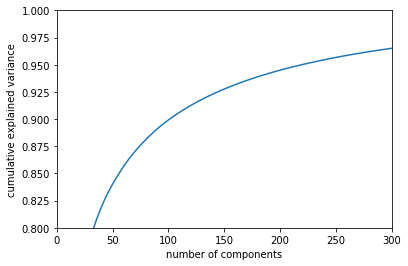

In [ ]:
plt.xlim([0,300])
plt.ylim([0.8,1.0])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(n_components=100)
principalComponents = pca.fit_transform(pcadata)
print(pca.explained_variance_)

[827.00498385 349.30885544 220.11210827 118.77862208 110.13793689
  90.93288468  86.3031569   66.1116588   64.68524539  46.1080737
  40.32798952  34.71838596  34.09880672  32.31117274  29.06915324
  25.49519534  23.655945    22.79820342  20.29413722  19.82623089
  18.65903897  18.41318707  15.9985036   15.680724    15.5022905
  15.00693767  14.35075136  14.11449761  12.85777841  12.43634024
  11.6890026   10.61463135  10.26881905   9.8049063    9.68191307
   9.10753204   8.42283092   8.36560874   8.18068537   7.99907954
   7.79920276   7.2336676    7.21618291   6.98886299   6.67973104
   6.55997643   6.14084335   6.03862545   5.88523672   5.76040412
   5.64310264   5.53230204   5.37782905   5.34078715   5.10928458
   5.05411492   5.03299343   4.90776377   4.89152505   4.78635236
   4.77511793   4.58985996   4.50453488   4.32119958   4.27000226
   4.22760042   4.13372132   3.93304291   3.88109682   3.84750833
   3.80065619   3.64770353   3.61689798   3.57959553   3.54765543
   3.4671102

In [ ]:
dflabels = pd.DataFrame({'target' : labels})
principalDf = pd.DataFrame(principalComponents)

In [ ]:
# Merger will be done after HOG and Color Historgram
#finalDf = pd.concat([principalDf, dflabels], axis = 1)

In [ ]:
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# targets = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# colors = ['r', 'g', 'b', 'black', 'yellow', 'pink', 'orange']
# for target, color in zip(targets,colors):
#     indicesToKeep = finalDf['target'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#                , c = color
#                , s = 20)
# ax.legend(targets)
# ax.grid()

### HOG

In [ ]:
import skimage.io, skimage.color
import numpy
import matplotlib.pyplot

def calculate_gradient(img, template):
    ts = template.size #Number of elements in the template (3).
    #New padded array to hold the resultant gradient image.
    new_img = numpy.zeros((img.shape[0]+ts-1, 
                           img.shape[1]+ts-1))
    new_img[numpy.uint16((ts-1)/2.0):img.shape[0]+numpy.uint16((ts-1)/2.0), 
            numpy.uint16((ts-1)/2.0):img.shape[1]+numpy.uint16((ts-1)/2.0)] = img
    result = numpy.zeros((new_img.shape))
    
    for r in numpy.uint16(numpy.arange((ts-1)/2.0, img.shape[0]+(ts-1)/2.0)):
        for c in numpy.uint16(numpy.arange((ts-1)/2.0, 
                              img.shape[1]+(ts-1)/2.0)):
            curr_region = new_img[r-numpy.uint16((ts-1)/2.0):r+numpy.uint16((ts-1)/2.0)+1, 
                                  c-numpy.uint16((ts-1)/2.0):c+numpy.uint16((ts-1)/2.0)+1]
            curr_result = curr_region * template
            score = numpy.sum(curr_result)
            result[r, c] = score
    #Result of the same size as the original image after removing the padding.
    result_img = result[numpy.uint16((ts-1)/2.0):result.shape[0]-numpy.uint16((ts-1)/2.0), 
                        numpy.uint16((ts-1)/2.0):result.shape[1]-numpy.uint16((ts-1)/2.0)]
    return result_img

def gradient_magnitude(horizontal_gradient, vertical_gradient):
    horizontal_gradient_square = numpy.power(horizontal_gradient, 2)
    vertical_gradient_square = numpy.power(vertical_gradient, 2)
    sum_squares = horizontal_gradient_square + vertical_gradient_square
    grad_magnitude = numpy.sqrt(sum_squares)
    return grad_magnitude

def gradient_direction(horizontal_gradient, vertical_gradient):
    grad_direction = numpy.arctan(vertical_gradient/(horizontal_gradient+0.00000001))
    grad_direction = numpy.rad2deg(grad_direction)
    grad_direction = grad_direction%180
    return grad_direction

def HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins):
    HOG_cell_hist = numpy.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
    
            diff = numpy.abs(curr_direction - hist_bins)
            
            if curr_direction < hist_bins[0]:
                first_bin_idx = 0
                second_bin_idx = hist_bins.size-1
            elif curr_direction > hist_bins[-1]:
                first_bin_idx = hist_bins.size-1
                second_bin_idx = 0
            else:
                first_bin_idx = numpy.where(diff == numpy.min(diff))[0][0]
                temp = hist_bins[[(first_bin_idx-1)%hist_bins.size, (first_bin_idx+1)%hist_bins.size]]
                temp2 = numpy.abs(curr_direction - temp)
                res = numpy.where(temp2 == numpy.min(temp2))[0][0]
                if res == 0 and first_bin_idx != 0:
                    second_bin_idx = first_bin_idx-1
                else:
                    second_bin_idx = first_bin_idx+1
            
            first_bin_value = hist_bins[first_bin_idx]
            second_bin_value = hist_bins[second_bin_idx]
            HOG_cell_hist[first_bin_idx] = HOG_cell_hist[first_bin_idx] + (numpy.abs(curr_direction - first_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
            HOG_cell_hist[second_bin_idx] = HOG_cell_hist[second_bin_idx] + (numpy.abs(curr_direction - second_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
    return HOG_cell_hist


In [ ]:
def onedtoimg(arr):
  arr = np.reshape(arr, (3, 1024))
  arr2 = np.add(arr[2], np.add(arr[0], arr[1]))
  img = np.reshape(arr2, (32, 32))
  img = np.divide(img, 255*3)
  return img

In [ ]:
#%ls
#%rm finalcog.csv dfhog.csv finalDf.csv

In [ ]:
if not os.path.isfile("dfhog.csv"): 
  hogfeature = []
  for i in range(len(data)):
    img = onedtoimg(data[0])
    img = skimage.color.rgb2gray(img)

    horizontal_mask = numpy.array([-1, 0, 1])
    vertical_mask = numpy.array([[-1],[0],[1]])

    horizontal_gradient = calculate_gradient(img, horizontal_mask)
    vertical_gradient = calculate_gradient(img, vertical_mask)

    grad_magnitude = gradient_magnitude(horizontal_gradient, vertical_gradient)
    grad_direction = gradient_direction(horizontal_gradient, vertical_gradient)

    grad_direction = grad_direction % 180
    hist_bins = numpy.array([10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])

    # Histogram of the first cell in the first block.
    cell_direction = grad_direction[:19, :19]
    cell_magnitude = grad_magnitude[:19, :19]
    hogfeature.append(HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins))
    # matplotlib.pyplot.bar(x=numpy.arange(9), height=HOG_cell_hist, align="center", width=0.8)
    # matplotlib.pyplot.show()
  dfhog = pd.DataFrame(data = hogfeature)
  dfhog.to_csv('dfhog.csv', index=False)
else:
  dfhog = pd.read_csv('dfhog.csv')

### Color histogram

In [ ]:
if not os.path.isfile("finalcog.csv"): 
  finalcog = []
  hist_bin = numpy.array([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
  for i in range(len(data)):
  
    r = []
    g = []
    b = []
    hr = []
    hg = []
    hb = []
    # INIT rgb                    [r, r]
        #                         [r, r]
    for j in range(256):
      r.append(0)
      g.append(0)
      b.append(0)
    # add rgb
    for j in range(1024):              # [ 0, 1.-251,252,253,254,255] INDEX
      r[data[i][j]] += 1               # [ 0.... 0,  0 , 0 , 0 , 4] r
      g[data[i][j+1024]] += 1          # [ 4.... 0,  0 , 0 , 0 , 0] g
      b[data[i][j+2048]] += 1          # [ 4.... 0,  0 , 0 , 0 , 0] b

    # r value
    displace = 0
    for i in range(len(hist_bin) - 1):
      start = hist_bin[i]
      end = hist_bin[i+1]
      sum = 0

      for i in range(end - start):
        sum = sum + r[i+ displace]
      hr.append(sum)
      displace += end - start

    # g value
    displace = 0
    for i in range(len(hist_bin) - 1):
      start = hist_bin[i]
      end = hist_bin[i+1]
      sum = 0

      for i in range(end - start):
        sum = sum + g[i+ displace]
      hg.append(sum)
      displace += end - start

    # B value
    displace = 0
    for i in range(len(hist_bin) - 1):
      start = hist_bin[i]
      end = hist_bin[i+1]
      sum = 0

      for i in range(end - start):
        sum = sum + b[i+ displace]
      hb.append(sum)
      displace += end - start

    res = []
    for i in range(20):
      res.append(hr[i] + hg[i] + hb[i])
    #print(res)

    finalcog.append(res)
  finalcogdf = pd.DataFrame(data = finalcog)
  finalcogdf.to_csv('finalcog.csv', index=False)
else:
  finalcogdf = pd.read_csv('finalcog.csv')
  finalcog = finalcogdf.to_numpy()

In [ ]:
print(dfhog)
print(finalcogdf)

              0         1         2  ...        17   18          19
0      8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
1      8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
2      8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
3      8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
4      8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
...         ...       ...       ...  ...       ...  ...         ...
49995  8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
49996  8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
49997  8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
49998  8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727
49999  8.105717  9.428407  9.018274  ...  2.552681  0.0  105.397727

[50000 rows x 20 columns]
         0    1    2    3    4    5    6  ...   13   14   15   16   17   18   19
0       21   48   79  160  192  245  177  ...  243  183  112   81   55   54 

In [ ]:
finalcog = finalcogdf.to_numpy()
finalhog = dfhog.to_numpy()

for i in range(len(finalcog)):
  for j in range(len(finalcog[0])):
    finalcog[i][j] += finalhog[i][j]
dfhogcog = pd.DataFrame(data = finalcog)

In [ ]:
finalDf = pd.concat([principalDf, dfhog, finalcogdf], axis = 1)

In [ ]:
print(finalDf)

               0          1          2          3  ...   16   17   18   19
0     -22.055738  12.284904   8.961351  -2.201911  ...   84   57   54  158
1       4.013549  -5.049156  25.395892   6.979457  ...  175  122  131  205
2      21.112303 -47.687197 -12.573551  11.007741  ...   36   31   20  128
3     -39.231269   2.334025   5.719679  -1.312523  ...   16   24   24  128
4     -15.571606 -16.687922   5.620042  11.580972  ...  108  128   99  173
...          ...        ...        ...        ...  ...  ...  ...  ...  ...
49995  25.147650 -26.486161  37.585963   1.325465  ...  247  295  369  374
49996  26.226940   5.532838 -28.546700 -14.302536  ...   92  153  137  175
49997  -5.790113 -44.924414  -4.247257   3.065315  ...   60   75   84  199
49998  42.391786 -16.551181  22.266030   4.706101  ...  186  241  244  274
49999  13.075387  -3.192219 -17.317491  -0.777152  ...  138  169  107  157

[50000 rows x 140 columns]


## TSNE

In [ ]:
#data2df = pd.concat([principalDf, dfhog], axis = 1)
data2 = finalDf.to_numpy()
df = data2[0:50000,:]
standardized_data = StandardScaler().fit_transform(df)
standardized_data.shape

(50000, 140)

In [ ]:
labels_1000 = labels[0:50000]
print(labels_1000.shape)
# labels_1000 = np.rot90(labels_1000)
# print(labels_1000.shape)
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(standardized_data)

(50000,)


In [ ]:
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
print(tsne_data)

[[-11.13367367   2.93290043   6.        ]
 [ -1.82534301 -10.92248058   9.        ]
 [ 14.60501957 -14.23086929   9.        ]
 ...
 [  4.38260889 -14.86326313   9.        ]
 [ 25.11963654   4.38183641   1.        ]
 [ -0.40631199  16.76461411   1.        ]]


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


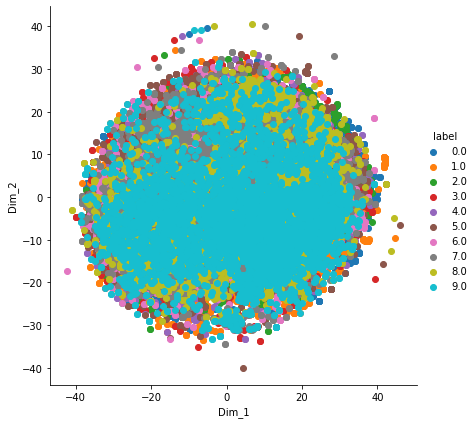

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

## Split

In [ ]:
def traintestsplit(df):
  shuffle = np.random.permutation(len(df))
  test_size = int(len(df) * 0.2)
  test_aux = shuffle[:test_size]
  train_aux = shuffle[test_size:]
  TRAIN_DF =df.iloc[train_aux]
  TEST_DF = df.iloc[test_aux]
#   print(len(TRAIN_DF))
#   print(len(TEST_DF))
  return TRAIN_DF, TEST_DF

In [ ]:
def split(train, test):
  ytrain = train['label'].copy()
  xtrain = train.drop(columns=['label'])
  ytest = test['label'].copy()
  xtest = test.drop(columns=['label'])

  return xtrain, ytrain, xtest, ytest

In [ ]:
data_5000 = data2[0:50000,:]
labels_5000 = labels[0:50000]
dflabels = pd.DataFrame(data = labels_5000, columns= ['label'])
dfdata = pd.DataFrame(data = data_5000)
df = pd.concat([dfdata, dflabels], axis = 1)
#print(df)
train, test = traintestsplit(df)
xtrain, ytrain, xtest, ytest = split(train, test)

## GridsearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

In [ ]:
# from sklearn.model_selection import GridSearchCV 
# from sklearn import svm
# # defining parameter range 
# param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#               'kernel': ['rbf']} 
  
# grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv = 5, n_jobs= 2) 
  
# # fitting the model for grid search 
# # print(xtr na

# grid.fit(xtrain, ytrain)

## Results

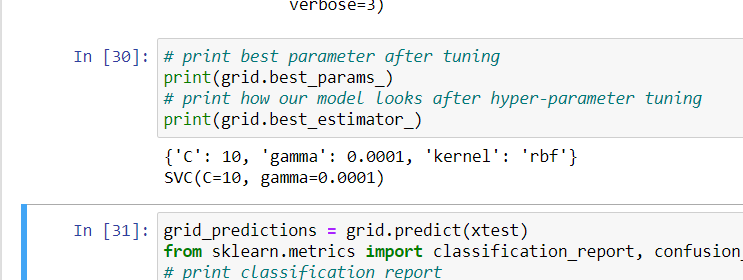

In [ ]:
# # print best parameter after tuning 
# print(grid.best_params_)
# # print how our model looks after hyper-parameter tuning 
# print(grid.best_estimator_)

In [ ]:
# grid_predictions = grid.predict(xtest)
# from sklearn.metrics import classification_report, confusion_matrix
# # print classification report
# print(classification_report(ytest, grid_predictions))

In [ ]:
import pickle
filename = "model1.sav"
# if not os.path.isfile("model1.sav"):
clf = svm.SVC(C = 10, gamma = 0.0001, kernel = 'rbf')
clf.fit(xtrain, ytrain)
clf.support_vectors_

# pickle.dump(open(filename, 'wb'))
# else:
#   clf = pickle.load(open(filename, 'rb'))

array([[  6.7731066 ,   5.47338642,   5.74456634, ...,  22.        ,
        733.        , 257.        ],
       [ -7.6940801 , -14.36013285,  11.03069275, ..., 164.        ,
        120.        , 142.        ],
       [ 81.96966906,  30.38635527,  -4.09129542, ...,  52.        ,
         50.        , 173.        ],
       ...,
       [ 36.21138973, -19.22567833, -15.42156231, ...,  58.        ,
         31.        , 141.        ],
       [ 16.8542626 , -27.87081196, -11.32932638, ..., 117.        ,
         50.        , 160.        ],
       [ 17.47986183, -35.24732721,  15.30321017, ..., 122.        ,
        115.        , 244.        ]])

In [ ]:
clf.score(xtest, ytest)

In [ ]:
clf.score(xtrain, ytrain)

In [ ]:
x_train = clf.support_vectors_
y_train = clf.support_

In [ ]:
clfnew = svm.SVC(C = 10, gamma = 0.0001, kernel = 'rbf')
clfnew.fit(x_train, y_train)

In [ ]:
clfnew.score(x_train, y_train)

In [ ]:
clfnew.score(xtest, ytest)

In [ ]:
# support_vectors_indices = best_model.support_

# x_train_support_vectors = []
# y_train_support_vectors = []

# for i in range(len(support_vectors_indices)):
#   x_train_support_vectors.append(new_train_data[support_vectors_indices[i]])
#   y_train_support_vectors.append(train_data_labels[support_vectors_indices[i]])

# x_train_support_vectors = np.array(x_train_support_vectors)
# y_train_support_vectors = np.array(y_train_support_vectors)

# clf = svm.SVC(C=10)
# clf.fit(x_train_support_vectors, y_train_support_vectors)
# train_pred = clf.predict(x_train_support_vectors)
# test_pred = clf.predict(new_test_data)
# train_acc = accuracy_score(y_train_support_vectors,train_pred)
# test_acc = accuracy_score(test_data_labels,test_pred)
# print("train accuracy", train_acc)
# print("test accuracy", test_acc)